In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from copy import deepcopy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [144]:
raw = pd.read_csv('Data/ER doctors.csv')
zip_lat_lon = pd.read_csv('Data/us-zip-coordinate.csv', delimiter=';')

In [562]:
def add_lat_long(data, lat_long):
    '''
        merge original data with geo-index to get longitude and latitude
    '''
    data = data.merge(lat_long, left_on='zipcode', right_on='Zip')
    data = data.drop(columns = ['nppes_provider_zip', 'Zip', 'geopoint', 'Daylight savings time flag', 'Timezone'])
    return data

def standardize(column):
    '''
        standardize a column 
    '''
    mean = np.mean(column)
    std = np.std(column)
    column = (column-mean)/std
    return column

def normalize(column):
    '''
        standardize a column 
    '''
    minimum = np.min(column)
    maximum = np.max(column)
    column = (column-minimum)/(maximum-minimum)
    return column

def outlier_removal(df, columns, z_threshold=3):
    '''
        remove rows that are outliers in given columns
        criteria: entries with z-score outside of the threshold
    '''
    for column in columns:
        avg = np.mean(df[column])
        std = np.std(df[column])
        threshold_upper = avg+std*z_threshold
        threshold_lower = avg-std*z_threshold
        df = df[df[column] <= threshold_upper]
        df = df[df[column] >= threshold_lower]
    
    return df
    
    
def kmeans_clustering(data, features, n = 5):
    '''
        run kmeans with n clusters and return the clustered data as well as scores
    '''
    subset = data[features]
    
    clusterer = KMeans(n_clusters=n, random_state=0)
    labels = clusterer.fit_predict(subset)
    
    centers = clusterer.cluster_centers_
    distance = clusterer.inertia_
    

    data['clusters'] = labels
    
    return data, centers, distance

In [555]:
# data cleaning and subsetting
data = deepcopy(raw[['nppes_provider_zip', 'provider_type','place_of_service','line_srvc_cnt',
 'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_Medicare_allowed_amt', 'average_submitted_chrg_amt', 'average_Medicare_payment_amt','average_Medicare_standard_amt']])


# adding geo data
data['zipcode'] = data.nppes_provider_zip.astype('int')
data = add_lat_long(data, zip_lat_lon)


# extra varaibles
data['total_spending'] = data['line_srvc_cnt'] * data['average_submitted_chrg_amt']
data['coverage_rate'] = data['average_Medicare_payment_amt']/data['average_Medicare_allowed_amt']

# further subsetting
data = data[data.place_of_service == 'F']

#outlier removal
data = outlier_removal(data, ['line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_Medicare_allowed_amt', 'average_submitted_chrg_amt', 'average_Medicare_payment_amt','average_Medicare_standard_amt', 'coverage_rate'])


In [492]:
# feature transformation (not actually used)
need_standardizing = ['average_submitted_chrg_amt','line_srvc_cnt', 'coverage_rate', 'total_spending']
need_log_transform = ['average_submitted_chrg_amt','line_srvc_cnt']

for feature in need_standardizing:
    data[feature+'_stdized'] = normalize(standardize(data[feature]))
                                                   

Geographical Clustering

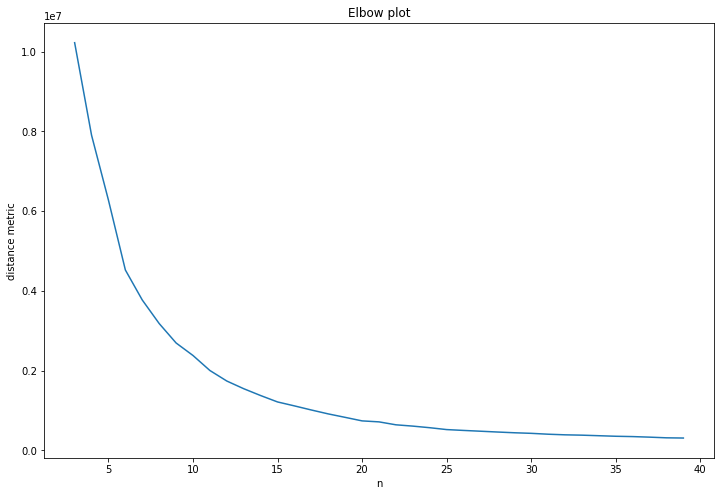

In [591]:
score_list = []
for i in range(3, 40):
    results, center, score = kmeans_clustering(data, ['Latitude', 'Longitude'], n=i)
    score_list.append(score)

plt.figure(figsize=(12, 8))
plt.title('Elbow plot')
plt.xlabel('n')
plt.ylabel('distance metric')
plt.plot(list(range(3, 40)), score_list)
plt.show()

In [620]:
results, center, score = kmeans_clustering(data, ['Latitude', 'Longitude'], n=200)
silhouette_score(results[['Latitude', 'Longitude']], results['clusters'], sample_size = 10000)

0.6080635405339093

In [590]:
cluster_groups = results.groupby('clusters').agg(['mean', 'median', 'count'])[['average_submitted_chrg_amt','line_srvc_cnt', 'coverage_rate', 'total_spending', 'Latitude', 'Longitude']]
cluster_groups.columns = cluster_groups.columns.map('_'.join).str.strip('_')

In [596]:
cluster_groups[['line_srvc_cnt_mean', 'coverage_rate_mean']].corr(method='spearman')

,line_srvc_cnt_mean,coverage_rate_mean
line_srvc_cnt_mean,1.000000,-0.162627
coverage_rate_mean,-0.162627,1.000000


Top 5 highest and lowest rates

In [632]:
# coverage rate
results.coverage_rate.describe()

count    175311.000000
mean          0.757614
std           0.043043
min           0.610659
25%           0.736333
50%           0.764023
75%           0.783663
max           0.889339
Name: coverage_rate, dtype: float64

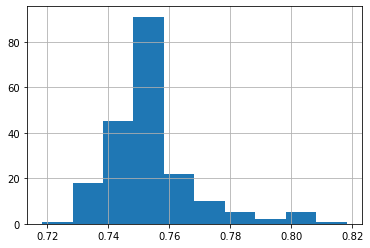

In [643]:
cluster_groups.coverage_rate_mean.hist()
plt.show()

In [646]:
cluster_groups.coverage_rate_mean.quantile(.05)

0.7347431344481634

In [636]:
highest = list(cluster_groups.sort_values('coverage_rate_mean', ascending=False)[0:10].index)
lowest = list(cluster_groups.sort_values('coverage_rate_mean')[0:10].index)
for high in highest:
    State = results[results.clusters == high].State
    print(State[0:1])
for low in lowest:
    State = results[results.clusters == low].State
    print(State[0:1])

130510    OR
Name: State, dtype: object
16384    CA
Name: State, dtype: object
28659    CA
Name: State, dtype: object
45168    CA
Name: State, dtype: object
2213    CA
Name: State, dtype: object
126783    CA
Name: State, dtype: object
9507    NC
Name: State, dtype: object
21797    CA
Name: State, dtype: object
65936    CA
Name: State, dtype: object
38697    FL
Name: State, dtype: object
168953    AZ
Name: State, dtype: object
100585    WY
Name: State, dtype: object
41855    MO
Name: State, dtype: object
6388    ME
Name: State, dtype: object
92116    WI
Name: State, dtype: object
42508    UT
Name: State, dtype: object
97507    NE
Name: State, dtype: object
67365    ND
Name: State, dtype: object
89235    WY
Name: State, dtype: object
21871    SD
Name: State, dtype: object


Top 5 highest and lowest average number of services

In [653]:
results.line_srvc_cnt.describe()

count    175311.000000
mean         94.100114
std          87.535096
min          11.000000
25%          28.000000
50%          61.000000
75%         132.000000
max         515.000000
Name: line_srvc_cnt, dtype: float64

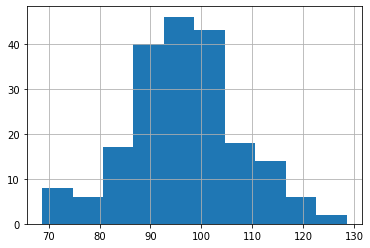

In [655]:
cluster_groups.line_srvc_cnt_mean.hist()
plt.show()

In [650]:
highest = list(cluster_groups.sort_values('line_srvc_cnt_mean', ascending=False)[0:10].index)
lowest = list(cluster_groups.sort_values('line_srvc_cnt_mean')[0:30].index)
for high in highest:
    State = results[results.clusters == high].State
    print(State[0:1])
for low in lowest:
    State = results[results.clusters == low].State
    print(State[0:1])

9507    NC
Name: State, dtype: object
117484    AK
Name: State, dtype: object
133919    SD
Name: State, dtype: object
40782    IN
Name: State, dtype: object
71510    WA
Name: State, dtype: object
3215    VA
Name: State, dtype: object
45428    NC
Name: State, dtype: object
10014    OH
Name: State, dtype: object
57649    SC
Name: State, dtype: object
5317    NC
Name: State, dtype: object
54605    CO
Name: State, dtype: object
125458    OR
Name: State, dtype: object
38423    MN
Name: State, dtype: object
38315    PR
Name: State, dtype: object
16843    CO
Name: State, dtype: object
191078    HI
Name: State, dtype: object
205807    AK
Name: State, dtype: object
168953    AZ
Name: State, dtype: object
102175    MN
Name: State, dtype: object
3725    MN
Name: State, dtype: object
7203    UT
Name: State, dtype: object
120570    AZ
Name: State, dtype: object
53651    NM
Name: State, dtype: object
43752    AZ
Name: State, dtype: object
7668    NJ
Name: State, dtype: object
48257    MI
Name: State

In [593]:
cluster_groups.to_csv('cluster_groups.csv')